<a href="https://colab.research.google.com/github/matchbou/kaggle-study-20190410/blob/master/02_Chainer_kaggle_tutorial-kadai06extra1fin-201904201604.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 02 Chainerでkaggleの問題を解こう！

このNotebookの目的は以下の通りです。

* kaggleのデータセットをダウンロードし、試しにsubmitしてみること
* 好きなデータセットをChainerで使えるように変換し、モデルの訓練・推論を行うこと
* kaggleを例題に、より応用的な画像識別の問題を解くこと
* fine-tuningをして、画像識別の問題を解くこと


## ColaboratoryでChainerを使うための設定

### 必要なライブラリ・Chainer・CuPyのインストール

下記のスクリプト内では、GPUを動かすのに必要なパッケージのインストール、Chainerのインストール、cudaのバージョンに応じたCuPyのインストールが行われています。

本来なら適切なバージョンの**CuPyをインストールする必要があります。**しかし、上記スクリプトはColaboratoryにインストールされているcudaのバージョンを見て、自動的に適切なCuPyをインストールします。

In [2]:
!curl https://colab.chainer.org/install | sh -

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1580  100  1580    0     0  25079      0 --:--:-- --:--:-- --:--:-- 25079
+ apt -y -q install cuda-libraries-dev-10-0
Reading package lists...
Building dependency tree...
Reading state information...
cuda-libraries-dev-10-0 is already the newest version (10.0.130-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 6 not upgraded.
+ pip install -q cupy-cuda100  chainer 
+ set +ex
Installation succeeded!


Chainer v4.0.0から`chainer.print_runtime_info()`という便利なメソッドが追加されました。以下のコマンドをターミナルで実行し、ChainerやCuPyが正しくインストールされたかを確認してみましょう。

In [3]:
!python -c 'import chainer; chainer.print_runtime_info()'

Platform: Linux-4.14.79+-x86_64-with-Ubuntu-18.04-bionic
Chainer: 5.0.0
NumPy: 1.16.2
CuPy:
  CuPy Version          : 5.2.0
  CUDA Root             : /usr/local/cuda
  CUDA Build Version    : 10000
  CUDA Driver Version   : 10000
  CUDA Runtime Version  : 10000
  cuDNN Build Version   : 7301
  cuDNN Version         : 7301
  NCCL Build Version    : 2307
iDeep: 2.0.0.post3


うまくインストールできていますね。以下の代表的なpythonパッケージを予めimportしておきましょう。

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import chainer

## Kaggleとは [1]

Kaggleは企業や研究者がデータを投稿し、世界中の統計家やデータ分析家がその最適モデルを競い合う、予測モデリング及び分析手法関連プラットフォーム。

### コンテスト参加の流れ
1. コンペティションの[リスト](https://www.kaggle.com/competitions)を見ると、現在・過去に開催されたコンペティションの一覧を見ることができる
2. 興味のあるコンペティションを選択し、「Join Competition」をクリックしコンペティションに参加する
3. コンペティションに参加すると、基本的には以下のデータにアクセスすることができる
    * trainデータ：訓練用の特徴量とラベルが入っているデータ。これを使ってモデルを訓練する。
    * testデータ：課題提出用のデータ。特徴量のみが入っており、それに適切なラベルを付与して回答する必要がある。
    * sample_sumbissionファイル：課題提出用ファイルのサンプル。どのように課題提出すればよいかわかる。
4. trainデータを使ってモデルを作成する
5.  testデータに対して、作ったモデルで推論を行う。その時の保存ファイルの形式はsample_sumbissionファイルに合わせる
6. 自分で作った課題提出用ファイルをsubmitする
7. リーダーボードで自分の現在の順位が確認できる

## kaggleコマンドの準備
準備として、Kaggleのデータセットを利用して何かしらの結果を提出してみましょう。手順は[リンク](https://qiita.com/fam_taro/items/eb9bae0b82248f9abd28)を参考にしています。


### kaggle コマンド(api) のインストール

In [5]:
!pip install kaggle

### kaggle API Key の入手

* https://www.kaggle.com/UserName/account で自分のアカウントページを開いてください
* 上記ページ内の Create New API Token をクリックして kaggle.json をダウンロードしてください

### Google ドライブに kaggle.json をアップロード

* https://drive.google.com/drive/my-drive を開いてください
* ドライブ上の好きな場所に kaggle.json をアップロードしてください

### Google ドライブから Colaboratory 上に kaggle.json をダウンロード

In [6]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

filename = "/root/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


### 各種コマンド操作

* digitがつくcompetitionsの検索

In [7]:
!kaggle competitions list -s digit

ref               deadline             category            reward  teamCount  userHasEntered  
----------------  -------------------  ---------------  ---------  ---------  --------------  
digit-recognizer  2030-01-01 00:00:00  Getting Started  Knowledge       2866            True  


* digit-recognizerのデータセットのダウンロード(予めコンペへの参加 (コンペルールへの同意) は済ませる必要がります)

In [8]:
!kaggle competitions download -c digit-recognizer

 86% 63.0M/73.2M [00:00<00:00, 81.4MB/s]
100% 73.2M/73.2M [00:00<00:00, 135MB/s] 
 90% 44.0M/48.8M [00:00<00:00, 51.6MB/s]
100% 48.8M/48.8M [00:00<00:00, 76.6MB/s]
  0% 0.00/235k [00:00<?, ?B/s]
100% 235k/235k [00:00<00:00, 196MB/s]


In [9]:
!ls /content/

adc.json  sample_data  sample_submission.csv  test.csv	train.csv


* コンペに提出

In [10]:
!head /content/sample_submission.csv

ImageId,Label
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


In [11]:
!kaggle competitions submit -c digit-recognizer -f /content/sample_submission.csv -m "Test"

100% 235k/235k [00:04<00:00, 50.4kB/s]
Successfully submitted to Digit Recognizer

## 自分でDatasetを作ってみよう

教師あり学習の場合、**データセットは「入力データ」と「それと対になるラベルデータ」を返すオブジェクトである必要があります。**
ChainerにはMNISTやCIFAR10/100のようなよく用いられるデータセットに対して、データをダウンロードしてくるところからそのような機能をもったオブジェクトを作るところまで自動的にやってくれる便利なメソッドがあるので、今まではそれを使っていました。

しかし、好きな問題を解くには自分でデータセットを作る必要があります。この節ではどのようにDatasetを作るか説明します。

まずは、pandasを使ってcsvを読み込んで見ましょう。訓練用データとテスト用データはそれぞれ以下のパスにダウンロードされています。

In [0]:
train_path = '/content/train.csv'
test_path = '/content/test.csv'

`pandas`を使ってcsvを読み込んでみましょう。`pandas`はpythonで頻繁にしようされるデータ操作・分析ライブラリです。`read_csv`で簡単にcsvファイルを読み込むことができます。



In [0]:
df_train_val = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

読み込んだデータは、以下のような`DataFrame`というテーブルデータ構造として扱われます。

In [14]:
df_train_val.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
df_test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Chainerで使用するデータセットのデータ構造は単純で、`train_val[i]`などとするとi番目の (data, label) というタプルを返すリストと同様のものになっています（実際ただのPythonリストもChainerのデータセットオブジェクトとして使えます)。

#### 課題1

 以下の`create_dataset`は上記で作成したDataFrameからChainerに則したデータセットを作る関数です。関数は以下のことに注意して定義する必要があります。
 
 * dataset[i]などとするとi番目の (data, label) というタプルを返すリストになっていること。
 * dataはfloat32型、labelはint32型であること。
 * 元画素値が0~255のint値だが、それを0~1のfloat値になるようにスケールすること。
 
 TODOの部分を穴埋めして、関数を完成させてください。解答はこの節の最後にあります。

In [0]:
def create_dataset(df):
    dataset = []
    for index, row in df.iterrows():
        data = #TODO
        dataset.append(data)
    return dataset

SyntaxError: ignored

In [0]:
def create_dataset(df, is_test = False):
    dataset = []
    for index, row in df.iterrows():
        data = (row.iloc[1:].values.astype('float32') /255.0, row.iloc[0].astype('int32'))
        dataset.append(data)
    return dataset

`create_dataset`を使って、chainer形式のデータセット`train_val`を作りましょう。



In [0]:
train_val = create_dataset(df_train_val)

データセットのサイズは以下のように、`42,000`となっています。

In [18]:
len(train_val)

42000

ここでは、`30.000`を訓練用データ、残りを検証用データに分割してみましょう。

In [0]:
train_size = 30000
train, validation = chainer.datasets.split_dataset_random(train_val, train_size, seed=0)

以下のように、意図したとおりに分割できていることがわかります。

In [20]:
len(train)

30000

In [21]:
len(validation)

12000

ここでは、おなじみの訓練と検証を行う関数`train_and_validate`を定義します。
詳しい説明は前回のハンズオンの資料を参照ください。

In [0]:
from chainer import optimizers, training
from chainer.training import extensions

def  train_and_validate(
        model, optimizer, train, validation, n_epoch, batchsize, device=0):

    # 1. deviceがgpuであれば、gpuにモデルのデータを転送する
    if device >= 0:
        model.to_gpu(device)

    # 2. Optimizerを設定する
    optimizer.setup(model)

    # 3. DatasetからIteratorを作成する
    train_iter = chainer.iterators.SerialIterator(train, batchsize)
    validation_iter = chainer.iterators.SerialIterator(
        validation, batchsize, repeat=False, shuffle=False)

    # 4. Updater・Trainerを作成する
    updater = training.StandardUpdater(train_iter, optimizer, device=device)
    trainer = chainer.training.Trainer(updater, (n_epoch, 'epoch'), out='out')

    # 5. Trainerの機能を拡張する
    trainer.extend(extensions.LogReport())
    trainer.extend(extensions.Evaluator(validation_iter, model, device=device), name='val')
    trainer.extend(extensions.PrintReport(
        ['epoch', 'main/loss', 'main/accuracy', 'val/main/loss', 'val/main/accuracy', 'elapsed_time']))
    trainer.extend(extensions.PlotReport(
        ['main/loss', 'val/main/loss'],x_key='epoch', file_name='loss.png'))
    trainer.extend(extensions.PlotReport(
        ['main/accuracy', 'val/main/accuracy'], x_key='epoch', file_name='accuracy.png'))
    trainer.extend(extensions.dump_graph('main/loss'))

    # 6. 訓練を開始する
    trainer.run()

ここでは、前回のハンズオンでFashion-MNISTの問題を解いたモデル`MyConvNet`を使用します。以前説明したように、MNISTとFashion-MNISTは入力データの次元数とラベル数が全く同じなので、同じモデルを使用することができます。

In [0]:
import chainer.functions as F
import chainer.links as L

class MyConvNet(chainer.Chain):
    def __init__(self):
        super(MyConvNet, self).__init__()
        with self.init_scope():
            self.conv1 = L.Convolution2D(
                in_channels=None, out_channels=32, ksize=3, stride=1, pad=1)
            self.conv2 = L.Convolution2D(
                in_channels=None, out_channels=64, ksize=3, stride=1, pad=1)
            self.conv3 = L.Convolution2D(
                in_channels=None, out_channels=128, ksize=3, stride=1, pad=1)
            self.conv4 = L.Convolution2D(
                in_channels=None, out_channels=128, ksize=3, stride=1, pad=1)
            self.fc5 = L.Linear(None, 2000)
            self.fc6 = L.Linear(None, 10)

    def __call__(self, x):
        h = F.dropout(F.relu(self.conv1(x.reshape((-1, 1, 28, 28)))), ratio=0.2)
        h = F.max_pooling_2d(h, ksize=2, stride=2)
        h = F.dropout(F.relu(self.conv2(h)), ratio=0.2)
        h = F.max_pooling_2d(h, ksize=2, stride=2)
        h = F.dropout(F.relu(self.conv3(h)), ratio=0.2)
        h = F.max_pooling_2d(h, ksize=2, stride=2)
        h = F.dropout(F.relu(self.conv4(h)))
        h = F.dropout(F.relu(self.fc5(h)))
        return self.fc6(h)

In [25]:
n_epoch = 10
batchsize = 128

model = MyConvNet()
classifier_model = L.Classifier(model)
optimizer = optimizers.Adam()
train_and_validate(
    classifier_model, optimizer, train, validation, n_epoch, batchsize
)

epoch       main/loss   main/accuracy  val/main/loss  val/main/accuracy  elapsed_time
1           0.301178    0.902028       0.107701       0.970578           12.3524       
2           0.0868807   0.972055       0.0685999      0.982602           15.3299       
3           0.0566169   0.982281       0.0530725      0.98637            18.3248       
4           0.0543173   0.982672       0.0472635      0.985788           21.4013       
5           0.0425664   0.986378       0.0459488      0.987367           24.3563       
6           0.0383191   0.98863        0.0545494      0.984375           27.3406       
7           0.0354925   0.988815       0.0348803      0.99011            30.295        
8           0.0297859   0.991052       0.0362398      0.990442           33.6636       
9           0.0298618   0.991157       0.042875       0.987838           37.1571       
10          0.0289146   0.990986       0.0398237      0.989417           40.6499       


#### 課題2

kaggleに結果をsubmitするためには、テストデータに対して作成したモデルで推論を行う必要があります。 以下はそのコードになります。関数は以下の引数によって`predictions = make_prediction(model, test)`と呼び出されることを想定しています。


* `test = (df_test.values / 255.0).astype("float32")`で生成されるnumpy配列
*  `model = MyConvNet()`で生成されたあと、既に学習が済んだモデル。注意が必要なのは、`L.Classifier`でwrapされる前なので、softmax関数やcross-entoropy関数を内部に持たない。

TODOの部分を穴埋めして、関数を完成させてください。解答はこの節の最後にあります。

In [0]:
import cupy as cp

def make_prediction(
    model, test, device = 0, batchsize = 256
):
    if device >= 0:
        model = model.to_gpu()
        xp = cp
    else:
        model = model.to_cpu()
        xp = np
   
    # 指定したbatchsizeごとにデータを分割している
    dataset = [
        xp.array(
            test[
                #TODO
            ]
        )
        for i in range((len(test) // batchsize + 1))
    ]
    
    predictions = []
    for d in dataset:
        with chainer.configuration.using_config('train', False):
            y = # TODO: 上記dに対して、modelにより推論を行う
            p = # TODO: yはsoftmax関数やcross-entoropy関数を経由していない。
            # ただ、最大値のcolumn番号が解答になるようになっている。
        predictions.extend(p)

    return predictions

In [0]:

import cupy as cp

def make_prediction(
    model, test, device = 0, batchsize = 256
):
    if device >= 0:
        model = model.to_gpu()
        xp = cp
    else:
        model = model.to_cpu()
        xp = np

    # 指定したbatchsizeごとにデータを分割している
    dataset = [
        xp.array(
            test[
                i * batchsize : (i + 1) * batchsize, :
            ]
        )
        for i in range((len(test) // batchsize + 1))
    ]

    predictions = []
    for d in dataset:
        with chainer.configuration.using_config('train', False):
            y = model(d)
            p = y.array.argmax(axis=1).astype("int32")
        predictions.extend(p)

    return predictions

In [0]:
test = (df_test.values / 255.0).astype("float32")

In [0]:
predictions = make_prediction(model, test)

`prediction`をprintしてみましょう。

In [29]:
print(predictions)

[array(2, dtype=int32), array(0, dtype=int32), array(9, dtype=int32), array(9, dtype=int32), array(3, dtype=int32), array(7, dtype=int32), array(0, dtype=int32), array(3, dtype=int32), array(0, dtype=int32), array(3, dtype=int32), array(5, dtype=int32), array(7, dtype=int32), array(4, dtype=int32), array(0, dtype=int32), array(4, dtype=int32), array(3, dtype=int32), array(3, dtype=int32), array(1, dtype=int32), array(9, dtype=int32), array(0, dtype=int32), array(9, dtype=int32), array(1, dtype=int32), array(1, dtype=int32), array(5, dtype=int32), array(7, dtype=int32), array(4, dtype=int32), array(2, dtype=int32), array(7, dtype=int32), array(4, dtype=int32), array(7, dtype=int32), array(7, dtype=int32), array(5, dtype=int32), array(4, dtype=int32), array(2, dtype=int32), array(6, dtype=int32), array(2, dtype=int32), array(5, dtype=int32), array(5, dtype=int32), array(1, dtype=int32), array(6, dtype=int32), array(7, dtype=int32), array(7, dtype=int32), array(4, dtype=int32), array(9, d

上記`prediction`をsubmit用のファイル形式に変換して保存しましょう。`sample_submission.csv`を表示して、ファイル形式を確認してみましょう。

In [30]:
!head /content/sample_submission.csv

ImageId,Label
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


In [0]:
from google.colab import files




files.download('sample_submission.csv')


上記のように、`ImageId`に1から始まるidが振られ、それに対応する`Label`が与えられたcsvファイルになります。

以下で、`df_submission`が上記の形式を満たすようにしましょう。

In [0]:
df_submission = pd.DataFrame(columns=["Label"], data=predictions)
df_submission.index += 1

`df_submission`の中身を確認すると、上記形式を満たしていることがわかります。

In [33]:
df_submission.head()

,Label
1,2
2,0
3,9
4,9
5,3


`df_submission`の大きさを確認して正しく`df_submission`が作成されていることを確認しましょう。

In [34]:
df_submission.shape

(28000, 1)

`df_sumbission`をcsvファイルとして、`submission_path`に保存しましょう。

In [0]:
submission_path = '/content/my_submission.csv'

In [44]:
!pwd

/content


In [43]:
!ls -a

.   adc.json  my_submission.csv  sample_data		test.csv
..  .config   out		 sample_submission.csv	train.csv


In [0]:
df_submission.to_csv(submission_path, index_label="ImageId")

念の為、正しく`submission_path`にファイルが保存されているか確認し、submitしてみましょう。

In [41]:
!head {submission_path}

ImageId,Label
1,2
2,0
3,9
4,9
5,3
6,7
7,0
8,3
9,0


In [42]:
!kaggle competitions submit -c digit-recognizer -f {submission_path} -m "My submission"

100% 208k/208k [00:04<00:00, 48.7kB/s]
Successfully submitted to Digit Recognizer

In [0]:
from google.colab import files




files.download('my_submission.csv')


submitしたものがどうだったかwebで確認できます。[digit-recognizer/leaderboard](https://www.kaggle.com/c/digit-recognizer/leaderboard)

![](https://user-images.githubusercontent.com/1277089/56186523-9551cd00-605a-11e9-84d6-ac36ce0e55cf.png)

#### 課題1の解答

In [0]:
def create_dataset(df, is_test = False):
    dataset = []
    for index, row in df.iterrows():
        data = (row.iloc[1:].values.astype('float32') /255.0, row.iloc[0].astype('int32'))
        dataset.append(data)
    return dataset

#### 課題2の解答

In [0]:
import cupy as cp

def make_prediction(
    model, test, device = 0, batchsize = 256
):
    if device >= 0:
        model = model.to_gpu()
        xp = cp
    else:
        model = model.to_cpu()
        xp = np
   
    # 指定したbatchsizeごとにデータを分割している
    dataset = [
        xp.array(
            test[
                i * batchsize : (i + 1) * batchsize, :
            ]
        )
        for i in range((len(test) // batchsize + 1))
    ]
    
    predictions = []
    for d in dataset:
        with chainer.configuration.using_config('train', False):
            y = model(d)
            p = y.array.argmax(axis=1).astype("int32")
        predictions.extend(p)

    return predictions

## 犬の種類の分類問題を解いてみよう

### データセットのダウンロード

次に犬の種種を分類する問題を解いてみましょう。同じくKaggleのお試しのコンペティションで[Dog Breed Identification](https://www.kaggle.com/c/dog-breed-identification)という名前です。

コンペティションの概要は以下の通りです。

* 画像識別問題
* RGB画像
* 識別対象の犬種は120種類


まずはデータをダウンロードしてみましょう。以外に早く終わるのであまりデータ数が多くないことがわかります。

In [46]:
data_dir = '/content/dog-breed-identification'
!mkdir -p {data_dir}
!kaggle competitions download -c dog-breed-identification -p {data_dir}

  0% 0.00/214k [00:00<?, ?B/s]
100% 214k/214k [00:00<00:00, 66.6MB/s]
  0% 0.00/281k [00:00<?, ?B/s]
100% 281k/281k [00:00<00:00, 86.3MB/s]
 98% 340M/346M [00:04<00:00, 74.1MB/s]
100% 346M/346M [00:04<00:00, 75.8MB/s]
 97% 334M/345M [00:05<00:00, 63.8MB/s]
100% 345M/345M [00:05<00:00, 63.4MB/s]


In [47]:
!ls {data_dir}

labels.csv.zip	sample_submission.csv.zip  test.zip  train.zip


データを解凍しましょう。

In [48]:
!unzip -qq '{data_dir}/*.zip' -d {data_dir}


4 archives were successfully processed.


試しに、`train`ディレクトリの中を見てみましょう。

以下のように、画像ファイル(.jpg)を含んでいることがわかります。

In [49]:
!ls {data_dir}/train -la | head -n10

total 374348
drwxr-xr-x 2 root root  651264 Sep 28  2017 .
drwxr-xr-x 4 root root    4096 Apr 20 06:22 ..
-rw-r--r-- 1 root root   54775 Sep 28  2017 000bec180eb18c7604dcecc8fe0dba07.jpg
-rw-r--r-- 1 root root   49514 Sep 28  2017 001513dfcb2ffafc82cccf4d8bbaba97.jpg
-rw-r--r-- 1 root root   33339 Sep 28  2017 001cdf01b096e06d78e9e5112d419397.jpg
-rw-r--r-- 1 root root   40134 Sep 28  2017 00214f311d5d2247d5dfe4fe24b2303d.jpg
-rw-r--r-- 1 root root   26442 Sep 28  2017 0021f9ceb3235effd7fcde7f7538ed62.jpg
-rw-r--r-- 1 root root   48129 Sep 28  2017 002211c81b498ef88e1b40b9abf84e1d.jpg
-rw-r--r-- 1 root root   31936 Sep 28  2017 00290d3e1fdd27226ba27a8ce248ce85.jpg


また、`labels.csv`の中も見てみましょう。

以下のように、画像ファイル名`id`とその犬種`breed`を記載したcsvファイルであることがわかります。

In [50]:
! cat {data_dir}/labels.csv | head -n10

id,breed
000bec180eb18c7604dcecc8fe0dba07,boston_bull
001513dfcb2ffafc82cccf4d8bbaba97,dingo
001cdf01b096e06d78e9e5112d419397,pekinese
00214f311d5d2247d5dfe4fe24b2303d,bluetick
0021f9ceb3235effd7fcde7f7538ed62,golden_retriever
002211c81b498ef88e1b40b9abf84e1d,bedlington_terrier
00290d3e1fdd27226ba27a8ce248ce85,bedlington_terrier
002a283a315af96eaea0e28e7163b21b,borzoi
003df8b8a8b05244b1d920bb6cf451f9,basenji


今回も`pandas`を使ってcsvファイルを読み込んでみましょう。

In [0]:
df_labels = pd.read_csv('{}/labels.csv'.format(data_dir))

In [52]:
df_labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


`breed`に対してユニークな要素`unique`を取ったところ、そのサイズは`120`となります。
コンペティションの概要の通り、全犬種数は120のようです。

In [53]:
len(df_labels.breed.unique())

120

ここで、データ数が多い順で犬種をsortしてみましょう。

In [0]:
sorted_breed_count = df_labels.groupby('breed').count().sort_values(by='id', ascending=False)

以下のように、最もデータ数が多いのは`scottish_deerhound`で、その数は`126`であることがわかります。120種類の識別問題でかつ、それぞれのデータは最大でも100程度しかないことがわかり、純粋に解くと難しい問題だなとなんとなく感じると思います。

In [55]:
sorted_breed_count.head()

,id
breed,
scottish_deerhound,126
maltese_dog,117
afghan_hound,116
entlebucher,115
bernese_mountain_dog,114


ここで、データ数の多い順で並んだ犬種`sorted_breed_name`を定義します。

In [0]:
sorted_breed_name = sorted_breed_count.index.values

int値のラベルから犬種への辞書`label2name`、犬種からint値のラベルへの辞書`name2label`を定義します。ここで、ラベルはデータ数の多い順に0,1,...とつけられていることに注意してください。

In [0]:
label2name = {
    i: name 
    for i, name 
    in enumerate(sorted_breed_name)
}

name2label = {
    name: i
    for i, name 
    in enumerate(sorted_breed_name)
}

def print_name(label):
    print('Name: {}'.format(label2name[label]))

`df_label`に`label`のcolumnを追加しましょう。

In [0]:
df_labels.loc[:, 'label'] = df_labels['breed'].apply(lambda name: name2label[name])

以下のようにそれぞれの`breed`に対して適切な`label`が付与されました。

In [59]:
df_labels.head()

,id,breed,label
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,42
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,72
2,001cdf01b096e06d78e9e5112d419397,pekinese,94
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,50
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,115


`scottish_deerhound`にはちゃんと`0`が割り当てられていますね。

In [60]:
df_labels[df_labels.breed == 'scottish_deerhound'].head()

,id,breed,label
9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound,0
79,01e787576c003930f96c966f9c3e1d44,scottish_deerhound,0
161,03dc61595ad9dbf49e3998cf586ca8cb,scottish_deerhound,0
233,056b535b441278e83839984f1b1da0a6,scottish_deerhound,0
235,05719b998e57a11b863a322ecc7652a5,scottish_deerhound,0


### 独自のデータセットクラスの定義

MNISTではデータセットをすべてメモリ上にロードしても特に問題ありませんでした。しかし、大規模な画像データセットで学習を行う場合、すべての画像データをメモリ上にロードできない場合があります。その場合、実際にデータを使う時に画像データをメモリにロードするという方法で問題を解決できます。今回は、それに対応できるように独自のデータセットクラスを定義してみましょう。

Chainerでは、データセットを表すクラスは以下の機能を持っていることが必要とされます。

* データセット内のデータ数を返す`__len__`メソッド
* 引数として渡される`i`に対応したデータもしくはデータとラベルの組を返す`get_example`メソッド

その他のデータセットに必要な機能は、`chainer.dataset.DatasetMixin`クラスを継承することで用意できます。ここでは、`DatasetMixin`クラスを継承して定義してみましょう。

#### 課題3

`get_example`の実装としては、以下を行う必要があります。

* 指定されたpathの画像をopenする
* PILをつかってリサイズ
* 適切なnumpy配列に変換
* Chainerの形式(channel, height, width)に変換

TODOの部分を穴埋めして、関数を完成させてください。解答はこの節の最後にあります。

In [0]:
from PIL import Image

class ResizedImageDataset(chainer.dataset.DatasetMixin):
    def __init__(self, pairs, size, dtype=np.float32):
        self._pairs = pairs  # (path, label)のlist
        self._size = size  # resizeするときのsize e.g. (224, 224)
        self._dtype = dtype  # numpy配列の型

    def __len__(self):
        # TODO

    def get_example(self, i):
        # データセットのインデックスを受け取って、画像を開きます
        path, label = self._pairs[i]
        img= Image.open(path)
        
        # PILをつかってリサイズ
        img = img.resize(self._size)
        
        # float32型のnumpy配列に変換
        img = np.asarray(img, dtype=self._dtype)
        
        # PILのImageは(height, width, channel)なので
        # Chainerの形式(channel, height, width)に変換
        img = # TODO

        return # TODO

In [0]:



from PIL import Image

class ResizedImageDataset(chainer.dataset.DatasetMixin):
    def __init__(self, pairs, size, dtype=np.float32):
        self._pairs = pairs  # (path, label)のlist
        self._size = size  # resizeするときのsize e.g. (224, 224)
        self._dtype = dtype  # numpy配列の型

    def __len__(self):
        return len(self._pairs)

    def get_example(self, i):
        # データセットのインデックスを受け取って、画像を開きます
        path, label = self._pairs[i]
        img= Image.open(path)

        # PILをつかってリサイズ
        img = img.resize(self._size)

        # float32型のnumpy配列に変換
        img = np.asarray(img, dtype=self._dtype)

        # PILのImageは(height, width, channel)なので
        # Chainerの形式(channel, height, width)に変換
        img = img.transpose(2, 0, 1)
        return img, label




`create_dataset`では以下を行います。

* `ResizedImageDataset`で画像サイズを`(224, 224)`にする
* `TransformDataset`でそれぞれの画素値の範囲を1~125から0.0~1.0に変更する。

In [0]:
def _transform(data):
    img, lable = data
    img = img / 255.0
    return img, lable

def create_dataset(class_size=120):
    # 上位class_size種類のデータのみを使用する
    df = df_labels[df_labels.label < class_size]
    
    # ResizedImageDatasetの作成
    dataset = ResizedImageDataset(
        # TODO,
        size=(224, 224),
    )
    
    # TransformDatasetの作成
    dataset = chainer.datasets.TransformDataset(dataset, _transform)
    return dataset

上記で作った関数を使ってみましょう。

In [0]:
def _transform(data):
    img, lable = data
    img = img / 255.0
    return img, lable

def create_dataset(class_size=120):
    # 上位class_size種類のデータのみを使用する
    df = df_labels[df_labels.label < class_size]

    # ResizedImageDatasetの作成
    dataset = ResizedImageDataset(
        [(data_dir + '/train/' + row['id'] + '.jpg', row['label']) for idx, row in df.iterrows()],
        size=(224, 224),
    )

    # TransformDatasetの作成
    dataset = chainer.datasets.TransformDataset(dataset, _transform)
    return dataset

In [0]:
dataset = create_dataset()

試しに`1`番目のデータの中身を見てみましょう。

In [0]:
data, l = dataset[1]

以下のように、`(channel, height, width)`の順に配列されている、かつ縦横のサイズが224になっていることが確認できると思います。

In [69]:
data.shape

(3, 224, 224)

実際にデータを画像として表示してみましょう。この際に、`(height, width,
 channel)`に直すことを忘れないでください。

Name: dingo


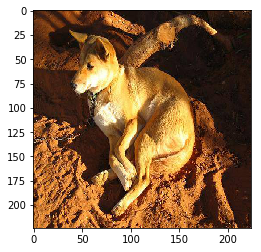

In [70]:
from PIL import Image

print_name(int(l))
plt.imshow(data.transpose(1, 2, 0))

訓練用データ全体のサイズを確認しましょう。

In [71]:
len(dataset)

10222

### ResNet

前回までのチュートリアルでは、独自のモデルを使用して学習を行っていましたが、今回は画像分野で有名なモデルを使用したいと思います。

以下は、2017年時点での有名なモデルの比較となります[2]。右図はそれぞれのモデルの精度、左図はそれぞれのモデルの精度と計算コスト、モデルサイズをplotしたものです。

![](https://pbs.twimg.com/media/C6wgUs7WoAAmBK7.jpg:large)

今回は、比較的計算コストが小さい、かつ精度が良いモデルを選ぶという観点で、「ResNet-50」を使いたいと思います。

ResNet-50の50は50層のネットワークのモデルと言う意味です。試しに、ResNet-34の図をお見せします。

![](https://user-images.githubusercontent.com/1277089/56078125-6b609680-5e1f-11e9-9a59-efe57ca62865.png)

cited from [3]

ResNet(Residual Networks)[3]は、ILSVRCという大規模画像認識コンペティションで2015年に優勝したモデルです。ResNetは、普通のネットワークのように求めたい変換を直接学習させるのではなく、入力との残差(residual)を学習させます。

以下で、2層のネットワークの入力を$x$、2層のネットワークが表現する関数を$F(x)$、2層のネットワークで表現したい関数を$H(x)$とします。

普通のネットワークの場合、$F(x)$が表現したい関数$H(x)$に近くなるように重みを学習させます。

![](https://user-images.githubusercontent.com/1277089/56078015-eb85fc80-5e1d-11e9-86ae-e92cebb8e0e8.png)

cited from [3]

ResNetの場合、residual blockによって、$F(x) + x$が表現したい関数$H(x)$に近くなるように重みを学習させます。この時、2層のネットワークが表現する関数$F(x)$は、表現したい関数$H(x)$と入力$x$の残差$H(x) - x$を学習することになります。

![](https://ai2-s2-public.s3.amazonaws.com/figures/2017-08-08/2c03df8b48bf3fa39054345bafabfeff15bfd11d/2-Figure2-1.png)

cited from [3]

このように、残差を学習させることによってどのようなメリットがあるかというと、

* 普通のネットワークでは層数が増えることによって、最終出力層の誤差を浅い層まで伝播させることが難しくなった(勾配消失問題)。しかし、ResNetの場合、入力を後続の処理に直接渡すこと(スキップ)によって、浅い層まで誤差を伝播させることが可能になった。そのおかげで、100以上の深いネットワークでも学習させることが可能になった。
* また、処理自体も入力をスキップするだけなので、実装が簡単

### ResNet50を使用したモデルの学習
では、このResNet50を使ってモデルを学習させていきましょう。

このデータセットの全犬種数は120ですが、それをすべて使って学習を行うとかなりの時間がかかってしまいます。それなので、今回はデータ数上位16種のみを使いたいと思います。

In [0]:
class_size = 16
dataset = create_dataset(class_size)

訓練用データと検証用データの比率を8:2にします。

In [0]:
train_rate = 0.8
train, validation = chainer.datasets.split_dataset_random(dataset, int(train_rate * len(dataset)), seed=0)

以下で、residual blockを定義しています。今回のResNet50では、residual blockにbottleneckバージョンのものを使います。bottleneckとはどういうものかというと、以下のように2層の同じチャネル数のCNNを挟むのではなく、3層のCNNを挟み、先頭の2つのCNNのチャネル数を小さくしたものになります。なぜbottleneckというかというと、中間で次元数を減らしておりbottleneckのような構造になっているからです。

![代替テキスト](https://user-images.githubusercontent.com/1277089/56078436-f3946b00-5e22-11e9-8d03-8d9a6496d317.png)

このようにすると、同じ計算量でありながらより深いモデルを学習させることができることがわかっています。

では、以下で`BottleNeck`クラスでブロックを定義してみましょう。
以下を見てわかるように、それぞれのCNNの間に実は`BatchNormalization`層と`relu`関数が挟まっています。

#### 課題4-1

`BottleNeck`クラスの`__init__`の引数は以下の通りです。下記引数はそれぞれ上記右図のどの値に対応するでしょうか。

* `n_in`
* `n_mid`
* `n_out`



#### 課題4-2

`BottleNeck`は`proj`の真偽値で処理を変更しています。なぜこのようなことが必要になるのでしょうか。

ヒント：`ResBlock`のどこで`proj`が`True`になっているか確認してみてください。

In [0]:
import chainer.functions as F
import chainer.links as L

class BottleNeck(chainer.Chain):
    def __init__(self, n_in, n_mid, n_out, stride=1, proj=False):
        w = chainer.initializers.HeNormal()
        super(BottleNeck, self).__init__()
        with self.init_scope():
            self.conv1x1a = L.Convolution2D(
                n_in, n_mid, 1, stride, 0, initialW=w, nobias=True)
            self.conv3x3b = L.Convolution2D(
                n_mid, n_mid, 3, 1, 1, initialW=w, nobias=True)
            self.conv1x1c = L.Convolution2D(
                n_mid, n_out, 1, 1, 0, initialW=w, nobias=True)
            self.bn_a = L.BatchNormalization(n_mid)
            self.bn_b = L.BatchNormalization(n_mid)
            self.bn_c = L.BatchNormalization(n_out)
            if proj:
                self.conv1x1r = L.Convolution2D(
                    n_in, n_out, 1, stride, 0, initialW=w, nobias=True)
                self.bn_r = L.BatchNormalization(n_out)
        self.proj = proj

    def forward(self, x):
        h = F.relu(self.bn_a(self.conv1x1a(x)))
        h = F.relu(self.bn_b(self.conv3x3b(h)))
        h = self.bn_c(self.conv1x1c(h))
        if self.proj:
            x = self.bn_r(self.conv1x1r(x))
        return F.relu(h + x)

`BottleNeck`ブロックを使って、`ResBlock`を定義しています。これは、同じチャネル数の`BottleNeck`を`n_layers`層重ねるブロックです。

In [0]:
class ResBlock(chainer.ChainList):
    def __init__(self, n_layers, n_in, n_mid, n_out, stride=2):
        super(ResBlock, self).__init__()
        self.add_link(BottleNeck(n_in, n_mid, n_out, stride, True))
        for _ in range(n_layers - 1):
            self.add_link(BottleNeck(n_out, n_mid, n_out))

    def forward(self, x):
        for f in self.children():
            x = f(x)
        return x

`ResBlock`を使って、`ResNet50`を定義します。

ざっと見て以下のような特徴があることがわかります。

* 基本的にはチャネル数を倍にしながら、`ResBlock`を重ねている。
* クラス数に合わせて、`self.fc6`の出力の次元が変わる。
* 最初に、`conv1`したあと、`max_pooling_2d`を行い、最後に`average_pooling_2d`をしている。

`ResNet-34`と比べると、`ResBlock`にそれぞれ何個の`BottleNeck`があるかは違いますが、ほとんど同じような構造をしていることがわかります。

In [0]:
class ResNet50(chainer.Chain):
    def __init__(self, class_size=120, n_blocks=[3, 4, 6, 3]):
        w = chainer.initializers.HeNormal()
        super(ResNet50, self).__init__()
        with self.init_scope():
            self.conv1 = L.Convolution2D(None, 64, 7, 2, 3, initialW=w, nobias=True)
            self.bn1 = L.BatchNormalization(64)
            self.res2 = ResBlock(n_blocks[0], 64, 64, 256, 1)
            self.res3 = ResBlock(n_blocks[1], 256, 128, 512)
            self.res4 = ResBlock(n_blocks[2], 512, 256, 1024)
            self.res5 = ResBlock(n_blocks[3], 1024, 512, 2048)
            self.fc6 = L.Linear(2048, class_size)

    def forward(self, x):
        h = self.bn1(self.conv1(x))
        h = F.max_pooling_2d(F.relu(h), 2, 2)
        h = self.res2(h)
        h = self.res3(h)
        h = self.res4(h)
        h = self.res5(h)
        h = F.average_pooling_2d(h, h.shape[2:], stride=1)
        h = self.fc6(h)
        return h

In [77]:
n_epoch = 5
batchsize = 32

model = ResNet50(class_size=class_size)
classifier_model = L.Classifier(model)
optimizer = optimizers.SGD()
train_and_validate(
    classifier_model, optimizer, train, validation, n_epoch, batchsize)

epoch       main/loss   main/accuracy  val/main/loss  val/main/accuracy  elapsed_time
1           3.57175     0.0652778      8.29141        0.0963542          17.4652       
2           3.42504     0.071733       9.56897        0.0520833          33.6645       
3           3.24543     0.0840278      3.16788        0.0598958          50.5002       
4           3.21599     0.0830966      3.65275        0.0572917          66.5243       
5           3.22281     0.09375        3.05194        0.0963542          82.8747       


上記のように、Colaboratoryの環境でResNetを学習させようと思うと、1epochあたり15秒と大変時間がかかってしまいます。また、5epoch学習させてみた結果を見たところ、検証用データにおける精度`val/main/accuracy`は10%以下で、とても数分で十分な精度まで学習することは難しそうです。

しかし、ここで諦める必要はありません。数epochである程度の精度まで学習させる手法がありますので、次の節ではその解説をします。

#### 課題3の解答


In [0]:
from PIL import Image

class ResizedImageDataset(chainer.dataset.DatasetMixin):
    def __init__(self, pairs, size, dtype=np.float32):
        self._pairs = pairs  # (path, label)のlist
        self._size = size  # resizeするときのsize e.g. (224, 224)
        self._dtype = dtype  # numpy配列の型

    def __len__(self):
        return len(self._pairs)

    def get_example(self, i):
        # データセットのインデックスを受け取って、画像を開きます
        path, label = self._pairs[i]
        img= Image.open(path)
        
        # PILをつかってリサイズ
        img = img.resize(self._size)
        
        # float32型のnumpy配列に変換
        img = np.asarray(img, dtype=self._dtype)
        
        # PILのImageは(height, width, channel)なので
        # Chainerの形式(channel, height, width)に変換
        img = img.transpose(2, 0, 1)
        return img, label

In [0]:
def _transform(data):
    img, lable = data
    img = img / 255.0
    return img, lable

def create_dataset(class_size=120):
    # 上位class_size種類のデータのみを使用する
    df = df_labels[df_labels.label < class_size]
    
    # ResizedImageDatasetの作成
    dataset = ResizedImageDataset(
        [(data_dir + '/train/' + row['id'] + '.jpg', row['label']) for idx, row in df.iterrows()],
        size=(224, 224),
    )
    
    # TransformDatasetの作成
    dataset = chainer.datasets.TransformDataset(dataset, _transform)
    return dataset

## fine-tuningを使ってみよう

**fine-tuning**とは、他のデータセットで既に訓練されたモデル(pretrained モデル)の重みを初期値として用いて、モデルの再学習を行うことです。 fine-tuningを行うことで以下が期待されます。

* 【学習時間が短い】 似たデータセットの課題を解くことができるモデルの重みを初期値として使うので、学習時間を短くすることができる。
* 【汎化性能が高い】pretrained モデルは大規模なデータセットで訓練されていることが多く、より汎用的な知識を学習していることが期待される

### pretrained(学習済み)モデルの用意

fine-tuningするには、初期値に使うpretrainedモデルが必要になります。有名なモデルに対しては、大規模なデータセットで訓練したpretrainedモデルが用意されていることが多いです。

Chainerでも、以下のようないくつかのpretrainedモデルにデフォルトで対応しております。

* VGG
* GoogLeNet
* ResNet

[一覧](https://docs.chainer.org/en/stable/reference/links.html#pre-trained-models)

これらのモデルは、caffemodel形式で保存されたモデルファイルを読み込み、重みを初期化します。デフォルトでは、それらのファイルが`~/.chainer/dataset/pfnet/chainer/models/`以下に配置してあることを期待しています。

現在、ResNet-50向けのcaffemodelは`wget`などでアクセスできるところに配置してありません。それなので、自分でダウンロードし、それをgdriveにuploadしましょう。

1. [リンク](https://github.com/KaimingHe/deep-residual-networks#models)にアクセスする
2. 「OneDrive download」をクリックする
3. 「ResNet-50-model.caffemodel」を自分のPCにダウンロードする
4. ダウンロードした「ResNet-50-model.caffemodel」を自分のgdriveの好きな場所にuploadする
5. 以下のコマンドを実行することで、先程配置した「ResNet-50-model.caffemodel」を`~/.chainer/dataset/pfnet/chainer/models/`以下にダウンロードする

In [79]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'ResNet-50-model.caffemodel'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

filename = "/root/.chainer/dataset/pfnet/chainer/models/ResNet-50-model.caffemodel"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


下記のコマンドを実行して、正しくダウンロードできたか確認してください。

In [80]:
!ls /root/.chainer/dataset/pfnet/chainer/models/ResNet-50-model.caffemodel

/root/.chainer/dataset/pfnet/chainer/models/ResNet-50-model.caffemodel


### fine-tuning用のモデルの用意

正しくpretrainedモデルを配置できている場合、`L.ResNet50Layers()`を使うことで自動的にpretrainedモデルを読み込んでくれます。ちなみに、`L.ResNet50Layers()`は先程私たちが自分で定義した`ResNet50`と同様なものとお考えください。実はわざわざ自分で`ResNet50`を定義しなくても良かったんですね。

In [0]:
import chainer.functions as F
import chainer.links as L

class PretrainedResNet50(chainer.Chain):
    def __init__(self, class_labels):
        super(PretrainedResNet50, self).__init__()

        with self.init_scope():
            self.base = L.ResNet50Layers()
            self.fc6 = L.Linear(None, class_labels)

    def forward(self, x):
        h = self.base(x, layers=['pool5'])['pool5']
        return self.fc6(h)

ここで1つ注意してもらいたいのが、`self.base(x, layers=['pool5'])['pool5']`というコードです。[ここ](https://github.com/chainer/chainer/blob/v5.4.0/chainer/links/model/vision/resnet.py#L127-L138)で各関数に対して名前をつけており、名前がつけられている部分の出力を取り出せるようになっています。今回は、`pool5`と指定して`global_average_pooling_2d`の出力を受け取り、`fc6`に結果を渡しています。

なぜ、このようなことをしているかというと、このpretrainedモデルは1000クラスの異なった画像データセットで訓練されており、今回解きたい問題と全く異なります。それなので、最後の部分だけ今回の`class_size=16`という問題に合うように、最終層だけ付け替えているのです。

では、さっそくこのモデルを使って学習させてみましょう。どうでしょうか。

In [82]:
n_epoch = 5
batchsize = 32

model = PretrainedResNet50(class_size)
classifier_model = L.Classifier(model)
optimizer = optimizers.SGD()
train_and_validate(
    classifier_model, optimizer, train, validation, n_epoch, batchsize)

Now loading caffemodel (usually it may take few minutes)


epoch       main/loss   main/accuracy  val/main/loss  val/main/accuracy  elapsed_time
1           1.70614     0.542361       2.89111        0.0625             17.0867       
2           0.4517      0.924716       0.78675        0.763021           34.7284       
3           0.190764    0.983333       0.434328       0.867188           52.0575       
4           0.10713     0.995028       0.394021       0.888021           68.6931       
5           0.0604081   0.999306       0.371658       0.893229           85.6703       


同じ5epochでも大きな違いがあることがわかると思います。

さらに、下ではpretrainedモデルで初期化した重みは更新せず、付け替えた最終層だけ訓練する方法をお見せします。`model.base`とすることで、内部の`L.ResNet50Layers`に
アクセスすることができ、それに対し`disable_update()`を呼ぶことで、その部分だけ重みを更新しないようになります。

In [83]:
n_epoch = 5
batchsize = 32

model = PretrainedResNet50(class_size)
classifier_model = L.Classifier(model)
optimizer = optimizers.SGD()

model.base.disable_update()

train_and_validate(
    classifier_model, optimizer, train, validation, n_epoch, batchsize)

epoch       main/loss   main/accuracy  val/main/loss  val/main/accuracy  elapsed_time
1           1.70365     0.528472       3.05212        0.101562           16.8969       
2           0.454356    0.925426       0.987193       0.682292           34.7037       
3           0.202301    0.976389       0.428737       0.877604           52.2034       
4           0.103315    0.993608       0.383762       0.869792           68.9062       
5           0.0653541   0.997222       0.376564       0.875              85.8859       


おそらく5epoch程度だと、重みを固定したほうが検証用データにおける精度は高くなると思います。

#### 課題5
ためしに他のpretraindedモデルも自分で定義して使ってみましょう。ためしに、vgg16など使ってみたらどうでしょうか。[Chainerの各種pretrainedモデル](https://docs.chainer.org/en/stable/reference/links.html#pre-trained-models)

In [0]:
class MyPretrainedModel(chainer.Chain):
    def __init__(self, class_labels):
        super(MyPretrainedModel, self).__init__()

        with self.init_scope():
            self.base = L.ResNet50Layers()
            self.fc6 = L.Linear(None, class_labels)

    def forward(self, x):
        h = self.base(x, layers=['pool5'])['pool5']
        return self.fc6(h)

In [85]:
n_epoch = 5
batchsize = 32

model = MyPretrainedModel(class_size)
classifier_model = L.Classifier(model)
optimizer = optimizers.SGD()

model.base.disable_update()

train_and_validate(
    classifier_model, optimizer, train, validation, n_epoch, batchsize)

epoch       main/loss   main/accuracy  val/main/loss  val/main/accuracy  elapsed_time
1           1.70436     0.549306       2.90101        0.101562           17.3475       
2           0.465946    0.924716       0.814888       0.776042           34.7262       
3           0.191557    0.979861       0.403655       0.895833           51.8664       
4           0.114669    0.994318       0.373926       0.880208           68.5788       
5           0.0708231   0.997917       0.344661       0.867188           85.5956       


## ChainerCVを使ってみよう

このハンズオンでは最後にChainerCVをご紹介したいと思います。ChainerCVとは、Chainerで実装された画像認識フレームワーク です。

まずはinstallしてみましょう。chainerと同様に、pipでinstallすることができます。簡単ですね。

In [86]:
!pip install chainercv

    100% |████████████████████████████████| 245kB 21.2MB/s 
  Stored in directory: /root/.cache/pip/wheels/48/34/47/ace83b5217d8cd49bd017951c776588fd4a7d8a1bf8817141a
Successfully built chainercv


In [0]:
import chainercv

ChainerCVには、画像処理向けに様々な機能が備わっています。

* 画像分野のデータセットに対するユーティリティ
* 画像処理
* 可視化
* 画像タスクに適したモデルの提供
    * 画像識別 (ResNet, SENet, VGG)
    * 物体検出 (Faster R-CNN, FPN, SSD, YOLO)
    * 画像セグメンテーション (SegNet, PSPNet, FCIS)
* 上記モデルに対するpretrainedモデルの提供


今回はChainerCVの機能を使って、**Data Augmentation**を行ってみたいと思います。

### Data Augmentationとは


Data Augmentation(データ拡張)とは、訓練用データに対してノイズや何かしらの処理を加えることで、複数のデータを作り出す手法です。これにより、同じデータから異なるデータを作りだすことが可能になり、訓練用データの水増しをすることができます。

画像でよく行われるData Augmentation手法としては以下などがあります。

* 左右反転
* 上下反転
* ランダムに切り抜き
* 回転

これらのData Augmentation手法は、その処理がデータの意味を変えないという事前知識に基づいて設計される場合が多いです。例えば画像の場合、左右反転・上下反転などの処理はその画像の意味を変えないと私たちは知っています。そのような事前知識をData Augmentation手法に反映させていると言えます。

#### 課題6

ChainerMNの画像を変換する関数を使ってみてその挙動を確認してみましょう。

今回使う関数には以下があります。

* random_sized_crop：ランダムに切り取る
* resize：指定したサイズにリサイズする
* random_flip：ランダムに反転する
* scale：指定したサイズに拡大・縮小する
* center_crop：指定したサイズで中央を切り取る

また、他にも色々用意されているので試してみてください。[リンク](https://chainercv.readthedocs.io/en/stable/reference/transforms.html#image)

In [0]:
dataset = create_dataset()
data, _ = dataset[1]

Name: dingo


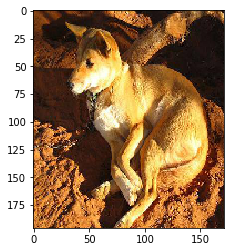

In [89]:
print_name(int(l))
img = chainercv.transforms.random_sized_crop(data)  # Change here
plt.imshow(img.transpose(1, 2, 0))

### ChainerCVによるData Augmentation

In [0]:
from PIL import Image

class ImageDataset(chainer.dataset.DatasetMixin):
    def __init__(self, pairs, size, dtype=np.float32):
        self._pairs = pairs  # (path, label)のlist
        self._size = size  # resizeするときのsize e.g. (224, 224)
        self._dtype = dtype  # numpy配列の型

    def __len__(self):
        return len(self._pairs)

    def get_example(self, i):
        # データセットのインデックスを受け取って、画像を開きます
        path, label = self._pairs[i]
        img= Image.open(path)
        
        # float32型のnumpy配列に変換
        img = np.asarray(img, dtype=self._dtype)
        
        # PILのImageは(height, width, channel)なので
        # Chainerの形式(channel, height, width)に変換
        img = img.transpose(2, 0, 1)
        return img, label

In [0]:
def _train_transform(data):
    img, lable = data
    img = chainercv.transforms.random_sized_crop(img)
    img = chainercv.transforms.resize(img, (224, 224))
    img = chainercv.transforms.random_flip(img, x_random=True)
    img = img / 255.0
    return img, lable

In [0]:
def _validation_transform(data):
    img, lable = data
    img = chainercv.transforms.scale(img, 256)
    img = chainercv.transforms.center_crop(img, (224, 224))
    img = img / 255.0
    return img, lable

In [0]:
def create_train_validation(class_size=120, train_rate=0.8):
    # 上位class_size種類のデータのみを使用する
    df = df_labels[df_labels.label < class_size]
    
    dataset = ImageDataset(
        [(data_dir + '/train/' + row['id'] + '.jpg', row['label']) for idx, row in df.iterrows()],
        size=(224, 224),
    )
    
    train, validation = chainer.datasets.split_dataset_random(
        dataset, int(train_rate * len(dataset)), seed=0
    )
    
    # train
    train = chainer.datasets.TransformDataset(
        train, _train_transform
    )
    
    # validation
    validation = chainer.datasets.TransformDataset(
        validation, _validation_transform
    )
    
    return train, validation

In [0]:
class_size = 16
train, validation = create_train_validation(class_size)

In [96]:
n_epoch = 5
batchsize = 32
class_label_size = len(df_labels.breed.unique())
model = PretrainedResNet50(class_size)
classifier_model = L.Classifier(model)
optimizer = optimizers.SGD()

classifier_model.predictor.base.disable_update()

train_and_validate(classifier_model, optimizer, train, validation, n_epoch, batchsize)

epoch       main/loss   main/accuracy  val/main/loss  val/main/accuracy  elapsed_time
1           1.87504     0.470833       3.01308        0.106771           17.989        
2           0.852274    0.773438       0.796006       0.763021           36.0808       
3           0.61705     0.827778       0.355273       0.90625            53.6271       
4           0.538397    0.84233        0.279574       0.914062           70.6934       
5           0.449766    0.867361       0.268924       0.927083           88.2577       


In [97]:
n_epoch = 10
batchsize = 32
class_label_size = len(df_labels.breed.unique())
model = PretrainedResNet50(class_size)
classifier_model = L.Classifier(model)
optimizer = optimizers.SGD()

classifier_model.predictor.base.disable_update()

train_and_validate(classifier_model, optimizer, train, validation, n_epoch, batchsize)

epoch       main/loss   main/accuracy  val/main/loss  val/main/accuracy  elapsed_time
1           1.92728     0.45           3.9955         0.0546875          17.666        
2           0.850911    0.784801       0.760515       0.755208           35.696        
3           0.624258    0.835417       0.297108       0.908854           53.2845       
4           0.510975    0.850142       0.347112       0.903646           70.3654       
5           0.427567    0.879861       0.284628       0.914062           87.9615       
6           0.386394    0.888494       0.265673       0.90625            105.358       
7           0.37144     0.892756       0.23054        0.927083           122.941       
8           0.380441    0.888889       0.255293       0.919271           140.701       
9           0.308261    0.914773       0.242186       0.934896           157.946       
10          0.343696    0.896528       0.237136       0.932292           175.473       


#### 課題7

このハンズオンで様々な手法を紹介しましたが、それを組み合わせてKaggleにsubmitしてみましょう。

## Reference

* [1][Wikipedia: Kaggle](https://ja.wikipedia.org/wiki/Kaggle)
* [2][An Analysis of Deep Neural Network Models for Practical Applications](https://arxiv.org/abs/1605.07678)
* [3][Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)